# Hugging Face and Sagemaker
### Fine-tuning DistilBERT with Amazon dataset

# Introduction

In this demo, we will use the Hugging Faces `transformers` and `datasets` library with Amazon SageMaker to fine-tune a pre-trained transformer on binary text classification. In particular, we will use the pre-trained DistilBERT model with the Amazon Reviews Polarity dataset.
We will then deploy the resulting model for inference using SageMaker Endpoint.

## The model

We'll be using an offshoot of [BERT](https://arxiv.org/abs/1810.04805) called [DistilBERT](https://arxiv.org/abs/1910.01108) that is smaller, and so faster and cheaper for both training and inference. A pre-trained model is available in the [`transformers`](https://huggingface.co/transformers/) library from [Hugging Face](https://huggingface.co/).

## The data

The [Amazon Reviews Polarity dataset](https://github.com/dsk78/Text-Classification---Amazon-Reviews-Polarity) consists of reviews from Amazon. The data span a period of 18 years, including ~35 million reviews up to March 2013. Reviews include product and user information, ratings, and a plaintext review. It's avalaible under the [`amazon_polarity`](https://huggingface.co/datasets/amazon_polarity) dataset on [Hugging Face](https://huggingface.co/).

# Setup

## Dependecies

In [1]:
#!pip install -qq sagemaker "transformers==4.4.2" "datasets[s3]" smdebug --upgrade
!pip install "boto3"
!pip install "sagemaker>=2.31.0" "transformers==4.4.2" "datasets[s3]==1.5.0" --upgrade
!pip install -qq watermark 
!pip install -qq "seaborn>=0.11.0"
!pip install -qq torch

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None


In [2]:
%reload_ext watermark
%watermark -v -p sagemaker,numpy,pandas,torch,transformers,datasets,seaborn

CPython 3.6.13
IPython 7.16.1

sagemaker 2.39.1
numpy 1.19.1
pandas 1.1.5
torch 1.6.0
transformers 4.4.2
datasets 1.5.0
seaborn 0.11.1


To use the new Debugger features, you need to upgrade the SageMaker Python SDK and the SMDebug client library. In your iPython kernel, Jupyter notebook, or JupyterLab environment, run the following code to install the latest versions of the libraries and restart the kernel. 

In [3]:
%%capture
import IPython
!conda install -c conda-forge ipywidgets -y
IPython.Application.instance().kernel.do_shutdown(True) # has to restart kernel so changes are used

## Development environment 

**upgrade ipywidgets for `datasets` library and restart kernel, only needed when prerpocessing is done in the notebook**

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import ProfilerConfig, DebuggerHookConfig, Rule, ProfilerRule, rule_configs
import sagemaker.huggingface
from sagemaker.huggingface import HuggingFace
import transformers
from transformers import AutoTokenizer
from datasets import load_dataset


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from textwrap import wrap

import boto3
import pprint
import time

In [4]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
AWS_STARTUPS_COLORS_PALETTE = ["#DE1A85", "#161E2D", "#52AFC2", "#8C297E", "#FF9900", "#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

#sns.set_theme(style="dark")

rcParams['figure.figsize'] = 17, 8

## Set up SageMaker session and bucket

In [5]:
sess = sagemaker.Session()
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::523588066826:role/service-role/AmazonSageMaker-ExecutionRole-20200723T165478
sagemaker bucket: sagemaker-us-east-1-523588066826
sagemaker session region: us-east-1


# Data preparation

The data preparation is straightforward as we're using the `datasets` library to download and preprocess the `
amazon_polarity` dataset directly from Hugging face. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job.

In [6]:
dataset_name = 'amazon_polarity'

train_dataset, test_dataset = load_dataset(dataset_name, split=['train', 'test'])
train_dataset = train_dataset.shuffle().select(range(80000)) # We're limiting the dataset size to speed up the training during the demo
test_dataset = test_dataset.shuffle().select(range(16000))

Reusing dataset amazon_polarity (/root/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/35b3f5f426863b55dda2d5dc0da2d3714c7b0e5ba64bc4f1415ac9291ffdb234)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/35b3f5f426863b55dda2d5dc0da2d3714c7b0e5ba64bc4f1415ac9291ffdb234/cache-06c53388bdae81d3.arrow


In [7]:
print(train_dataset.column_names)

['content', 'label', 'title']


In [8]:
train_dataset[0]

{'content': 'Little Slow on Review.. I only get to read at Dr Appts and other type breaks in day.Worth the read and I can understand mind set of why book is popular in war zones.I would suggest it to anyone that enjoys military reading..',
 'label': 1,
 'title': 'Soild Number 1 Book In Iraq and Afganastan'}

The dataset is already well balanced

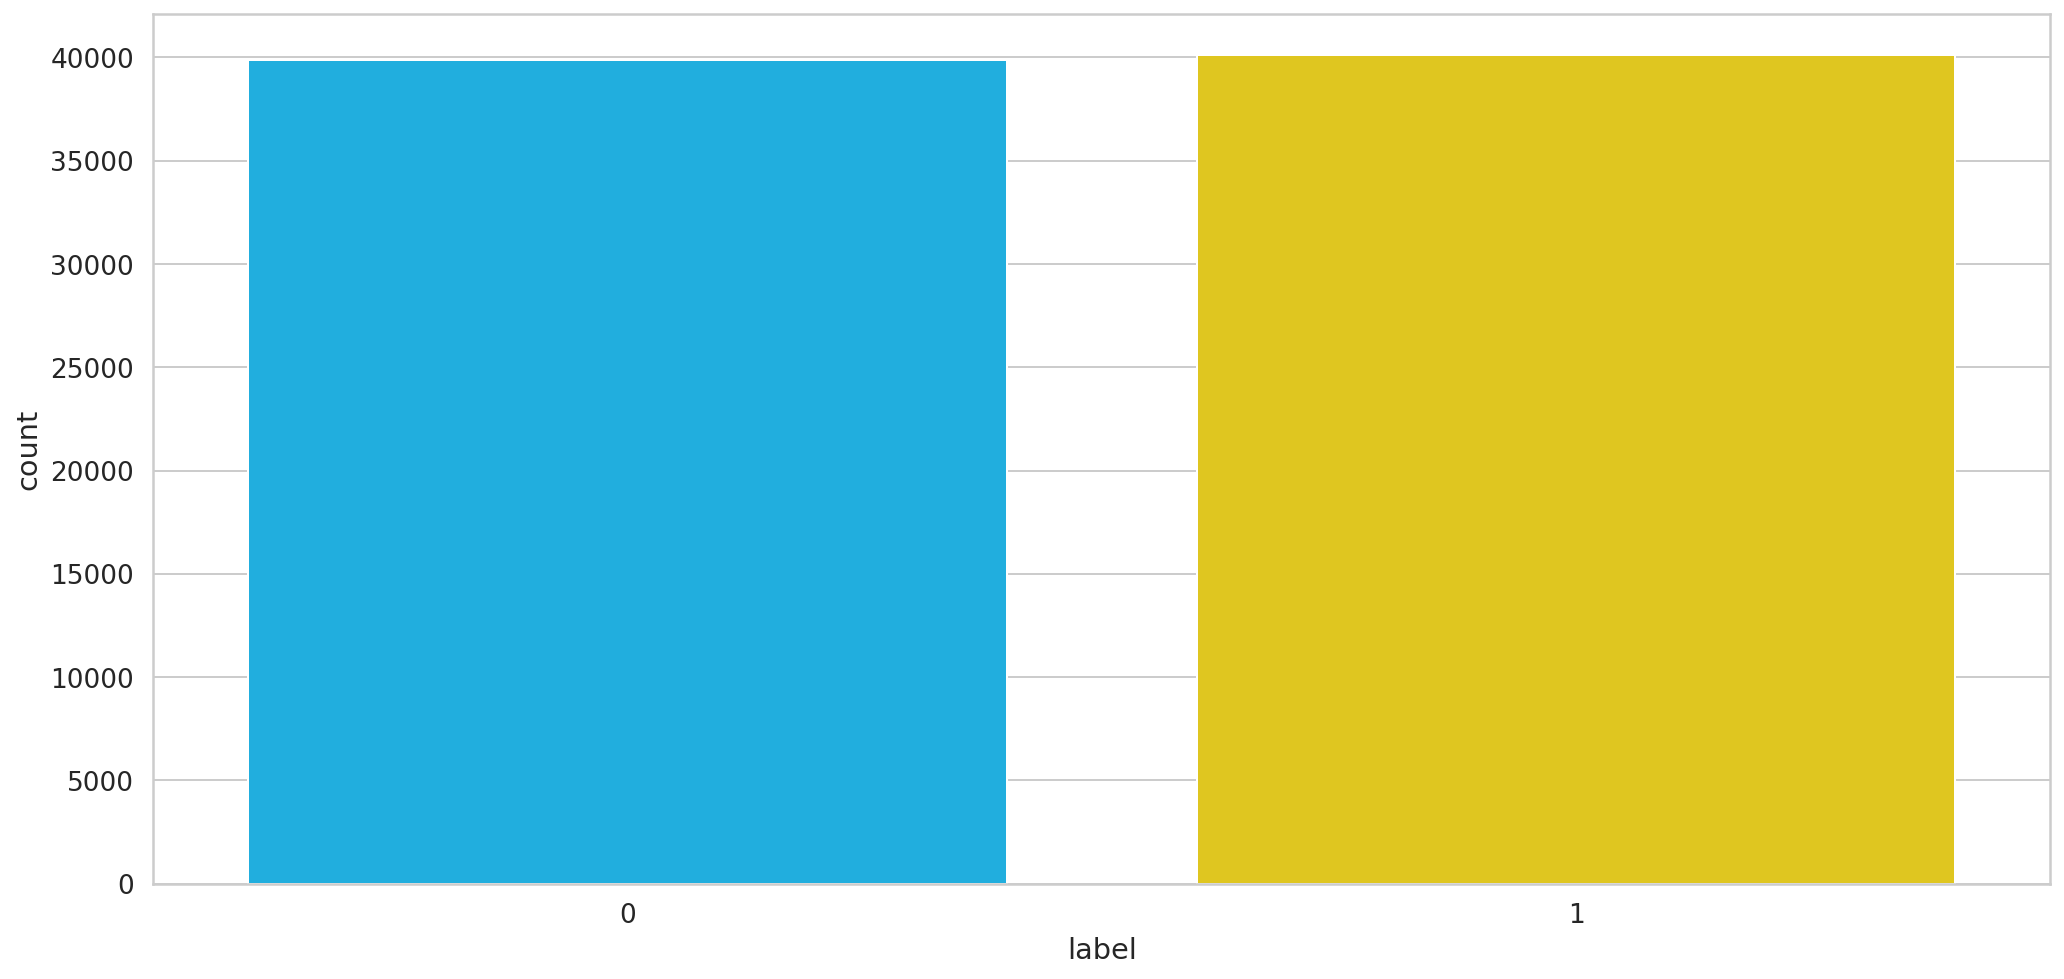

In [9]:
sns.countplot(x=train_dataset['label'])
plt.xlabel('label');

## Preparing the dataset to be used with PyTorch
Now that we have the dataset the need to convert it for training. This means using a tokenizer and getting the PyTorch tensors. Hugging Face provides an [`AutoTokenizer`](https://huggingface.co/transformers/model_doc/auto.html#autotokenizer)

This downloads the tokenizer:

In [10]:
tokenizer_name = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

And this tokenize our training and testing datasets and then set them to the PyTorch format:

In [11]:
# Helper function to get the content to tokenize
def tokenize(batch):
    return tokenizer(batch['content'], padding='max_length', truncation=True)

# Tokenize
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

# Set the format to PyTorch
train_dataset.rename_column_("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.rename_column_("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

rename_column_ is deprecated and will be removed in the next major version of datasets. Use the dataset.rename_column method instead.


## Uploading the data to S3

Now that the data as been processed we can upload it to S3 for training

In [12]:
import botocore
from datasets.filesystems import S3FileSystem

# Upload to S3
s3 = S3FileSystem()
s3_prefix = f'samples/datasets/{dataset_name}'
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path,fs=s3)
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path,fs=s3)

print(f'Uploaded training data to {training_input_path}')
print(f'Uploaded testing data to {test_input_path}')

Uploaded training data to s3://sagemaker-us-east-1-523588066826/samples/datasets/amazon_polarity/train
Uploaded testing data to s3://sagemaker-us-east-1-523588066826/samples/datasets/amazon_polarity/test


# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job we need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In a Estimator we define, which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in .....



```python
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.4',
                            pytorch_version='1.6',
                            py_version='py36',
                            hyperparameters = hyperparameters)
```

When we create a SageMaker training job, SageMaker takes care of starting and managing all the required ec2 instances for us with the `huggingface` container, uploads the provided fine-tuning script `train.py` and downloads the data from our `sagemaker_session_bucket` into the container at `/opt/ml/input/data`. Then, it starts the training job by running. 

```python
/opt/conda/bin/python train.py --epochs 1 --model_name distilbert-base-uncased --train_batch_size 32
```

The `hyperparameters` you define in the `HuggingFace` estimator are passed in as named arguments. 

Sagemaker is providing useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.

In [13]:
!pygmentize ./scripts/train.py

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_from_disk
import random
import logging
import sys
import argparse
import os
import torch

if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train-batch-size", type=int, default=32)
    parser.add_argument("--eval-batch-size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)

    # Data, model, and output directories
    parser.add_argument("--output-data-dir", type=str, default=os.environ["SM_OUTPUT_DATA_DIR"])
    parser.add_argument("--model-dir", type=s

## Creating an Estimator and start a training job

In [14]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules=[ 
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),    
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    ProfilerRule.sagemaker(rule_configs.BatchSize()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),   
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [15]:
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)

Name our training job so we can follow it:

In [16]:
model_name = 'distilbert-base-uncased'
import datetime
ct = datetime.datetime.now() 
current_time = str(ct.now()).replace(":", "-").replace(" ", "-")[:19]
training_job_name=f'finetune-{model_name}-{current_time}'
print( training_job_name )

full-distilbert-base-uncased-2021-05-07-01-02-03


In [17]:
hyperparameters={'gpu': True,
                 'epochs': 50,
                 'train_batch_size': 1024,
                 'model_name': model_name,
                 'output_dir':'/opt/ml/checkpoints'
                 }
checkpoint_s3_uri = f's3://{sess.default_bucket()}/{training_job_name}/checkpoints'

In [18]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

In [19]:
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.16xlarge',
                            instance_count=2,
                            role=role,
                            transformers_version='4.4', # currently only supports 4.4.2
                            pytorch_version='1.6',
                            py_version='py36',
                            hyperparameters = hyperparameters,
                            metric_definitions=metric_definitions,
                            checkpoint_s3_uri=checkpoint_s3_uri,
#                            use_spot_instances=True, # Using Spot instances
#                            max_wait=3600, # This should be equal to or greater than max_run in seconds'
                            max_run=3600, # expected max run in seconds
                            profiler_config=profiler_config,
                            rules=rules                                        
                        )

Starts the training job using the estimator fit function:

In [20]:
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path}, wait=False, job_name=training_job_name )

In [21]:
print(huggingface_estimator.rules)

[Rule(name='LossNotDecreasing', image_uri='503895931360.dkr.ecr.us-east-1.amazonaws.com/sagemaker-debugger-rules:latest', instance_type=None, container_local_output_path=None, s3_output_path=None, volume_size_in_gb=None, rule_parameters={'rule_to_invoke': 'LossNotDecreasing'}), Rule(name='Overfit', image_uri='503895931360.dkr.ecr.us-east-1.amazonaws.com/sagemaker-debugger-rules:latest', instance_type=None, container_local_output_path=None, s3_output_path=None, volume_size_in_gb=None, rule_parameters={'rule_to_invoke': 'Overfit'}), Rule(name='Overtraining', image_uri='503895931360.dkr.ecr.us-east-1.amazonaws.com/sagemaker-debugger-rules:latest', instance_type=None, container_local_output_path=None, s3_output_path=None, volume_size_in_gb=None, rule_parameters={'rule_to_invoke': 'Overtraining'}), Rule(name='VanishingGradient', image_uri='503895931360.dkr.ecr.us-east-1.amazonaws.com/sagemaker-debugger-rules:latest', instance_type=None, container_local_output_path=None, s3_output_path=None,

Wait for the training to finish.

In [ ]:
sm = boto3.client('sagemaker')

# check training job status every minute
stopped = False
while not stopped:
    state = sm.describe_training_job(
        TrainingJobName=training_job_name)
    if state['TrainingJobStatus'] in ['Completed', 'Stopped', 'Failed']:
        stopped=True
    else:
        print("Training in progress")
        time.sleep(60)

if state['TrainingJobStatus'] == 'Failed':
    print("Training job failed ")
    print("Failed Reason: {}".state['FailedReason'])
else:
    print("Training job completed")

Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress


## Training metrics
We can now display the training metrics

In [ ]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=training_job_name).dataframe()
df.head(10)

And plot the collected metrics

In [ ]:
evals = df[df.metric_name.isin(['eval_accuracy','eval_precision', 'eval_f1'])]
losses = df[df.metric_name.isin(['loss', 'eval_loss'])]

sns.lineplot(
    x='timestamp', 
    y='value', 
    data=evals, 
    style='metric_name',
    markers=True,
    hue='metric_name'
)

ax2 = plt.twinx()
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=losses, 
    hue='metric_name',
    ax=ax2)

# Endpoint
We'll now proceed and create an endpoint to provide inference with the trained model.

_** Not working yet. Future release **_


In [ ]:
huggingface_model_name = f'hf-{model_name}'
huggingface_model = huggingface_estimator.create_model(Name=huggingface_model_name)
predictor = huggingface_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

_** Runs prediction localy until the SDK and inference image are available **_

In [ ]:
print(huggingface_estimator.model_data)
%%sh -s $huggingface_estimator.model_data
aws s3 cp $1 .
mkdir -p model
tar xvfz model.tar.gz -C model

Using Hugging Face to create the model we'll be using for inference.

In [ ]:
from transformers import AutoModel, AutoConfig, DistilBertForSequenceClassification

config = AutoConfig.from_pretrained('./model/config.json')
model = DistilBertForSequenceClassification.from_pretrained('./model/pytorch_model.bin', config=config)

print(config)

Running a sample review through the tokenizer and a pass forward.

In [ ]:
review = "This is great product. I'll definitly recommand it to my freinds!"
#review = "Many are not compatible and breakdown. Don't get ripped off."
inputs = tokenizer(review, return_tensors='pt')
outputs = model.forward(**inputs)

Transforms the logits into a 0|1 classification

In [ ]:
import torch
import numpy as np

softmax = torch.nn.Softmax(dim=1)
pred = np.argmax(softmax(outputs.logits).detach().numpy(), axis=1)

print(f'Prediction for \"{review}\" : {pred}')

In [ ]:
!mkdir ./model/code/
!cp ./scripts/requirements.txt ./model/code/
!cp ./scripts/inference.py ./model/code/


In [ ]:
torch.save(model,"model/model.pth")

In [ ]:
!tar cvfz model.tar.gz ./model

In [ ]:
s3_client = boto3.client('s3')

model_s3_prefix = f'models/{training_job_name}'
model_s3_path = f's3://{sess.default_bucket()}/{model_s3_prefix}/model.tar.gz'
s3_client.upload_file('model.tar.gz', sess.default_bucket(), f'{model_s3_prefix}/model.tar.gz')

print(f'Uploaded training data to {model_s3_path}')

In [ ]:
pytorch_model = sagemaker.pytorch.model.PyTorchModel(model_data=model_s3_path, role=role,
                                                     framework_version='1.6', py_version='py36',
                                                     entry_point='model/code/inference.py')

In [ ]:
predictor = pytorch_model.deploy(instance_type='ml.c4.xlarge', initial_instance_count=1)